In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
import emcee
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
class ROSATxLike(object):
    def __init__(self, year=3,
                 params_vary=['lMc', 'alpha_T'],
                 priors={'lMc': [13.0, 15.0], 'alpha_T': [0.1, 2.0]},
                 bins=[0, 1, 2, 3], Zmetal=0.3, lines=True, lmin=30,
                 lmax=2048, mbias=[-0.0063, -0.0198, -0.0241, -0.0369],
                 zbias=[0.0, 0.0, 0.0, 0.0], with_clumping=True):
        self.params_vary = params_vary
        self.priors = priors
        self.Zmetal = Zmetal
        self.lines = lines
        self.wclump = with_clumping
        # Load data
        s = sacc.Sacc.load_fits(f'data/cls_cov_Y{year}iv_marg_dz_m.fits')
        # Scale cuts
        s.keep_selection(ell__gt=lmin, ell__lt=lmax)
        self.bins = bins
        # Read info about all C_ells and the dNdzs
        indices = []
        self.cl_meta = []
        self.dndzs = {}
        for i in self.bins:
            tn = f'DESY{year}wl__{i}'
            leff, cld, cov, ind = s.get_ell_cl('cl_0e','ROSAT', tn, return_cov=True, return_ind=True)
            indices += list(ind)
            self.cl_meta.append({'t1': 'ROSAT',
                                 't2': tn,
                                 'ls': leff,
                                 'cld': cld,
                                 'cov': cov,
                                 'icov': np.linalg.inv(cov),
                                 'ind': ind,
                                 'mplusone': 1+mbias[i], 
                                 'beam': self.beam(leff)})
            tr = s.tracers[tn]
            self.dndzs[tn] = (tr.z+zbias[i], tr.nz)
        indices = np.array(indices)

        # Reorganise data
        self.data = s.mean[indices]
        self.cov = s.covariance.dense[indices][:, indices]
        self.inv_cov = np.linalg.inv(self.cov)
        self.ndata = len(self.data)

        # Get X-ray spectrum
        self.get_spectrum()

        # Initialise theory model
        self.init_model()

    def beam(self, ell, nside=1024):
        fwhm_hpx_amin = 60*41.7/nside
        sigma_hpx = np.radians(fwhm_hpx_amin/60)/2.355
        sigma_ROSAT = np.radians(1.8e0/60)/2.355
        sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_hpx**2
        return np.exp(-0.5*sigma_tot_2*ell*(ell+1))

    def get_spectrum(self):
        kTmin = 0.02
        kTmax = 50.0
        nkT = 32
        zmax = 4.0
        nz = 16
        emin = 0.5
        emax = 2.0

        fname = 'data/J'
        if self.lines:
            fname += 'tot'
        else:
            fname += 'cont'
        fname += '_Z%.2lf' % self.Zmetal
        fname += '.pck'
        print(fname)
        if os.path.isfile(fname):
            with open(fname, "rb") as f:
                J = pickle.load(f)
        else:
            print('Calculating')
            rs = rx.ROSATResponse('data/pspcc_gain1_256.rsp', Zmetal=self.Zmetal)
            J = rs.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                                  dolines=self.lines, dopseudo=self.lines)
            with open(fname, "wb") as f:
                pickle.dump(J, f)
        self.J = J

    def init_model(self):
        COSMO_P18 = {"Omega_c": 0.26066676,
                     "Omega_b": 0.048974682,
                     "h": 0.6766,
                     "n_s": 0.9665,
                     "sigma8": 0.8102,
                     "matter_power_spectrum": "linear"}
        self.cosmo = ccl.Cosmology(**COSMO_P18)
        mdef = ccl.halos.MassDef200c
        cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
        nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
        bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
        self.hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=mdef,
                                          log10M_max=15., log10M_min=10, nM=32)
        self.prof_dens = rx.HaloProfileDensityHE(mass_def=mdef,
                                                 concentration=cM,
                                                 kind='n_total')
        self.prof_pres = rx.HaloProfilePressureHE(mass_def=mdef,
                                                  concentration=cM,
                                                  kind='n_total')
        self.prof_matter = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
        self.prof_xray = rx.HaloProfileXray(mass_def=mdef, Jinterp=self.J,
                                            dens=self.prof_dens, pres=self.prof_pres,
                                            fourier_approx=False,
                                            with_clumping=self.wclump)
        # Initialize tracers
        self.tx = rx.XrayTracer(self.cosmo)
        self.tgs = {k: ccl.WeakLensingTracer(self.cosmo, dndz=v) for k, v in self.dndzs.items()}

        # Fixed k and a arrays
        k_arr = np.geomspace(1e-4, 100, 256)
        self.lk_arr = np.log(k_arr)
        self.a_arr = np.linspace(0.3,1,8)

    def default_params(self):
        return {'lMc': 14.0, 'alpha_T': 1.0}

    def params_to_dict(self, pvec):
        pdict = self.default_params() 
        for k, v in zip(self.params_vary, pvec):
            pdict[k] = v
        return pdict

    def update_params(self, pdict):
        kwargs = {k: pdict.get(k, None) for k in ['lMc', 'alpha_T', 'logTAGN']}
        self.prof_dens.update_parameters(**kwargs)
        self.prof_pres.update_parameters(**kwargs)

    def get_model(self, **kwargs):
        self.update_params(kwargs)
        pkx = ccl.halos.halomod_Pk2D(self.cosmo, self.hmc,
                                     self.prof_matter, prof2=self.prof_xray,
                                     lk_arr=self.lk_arr, a_arr=self.a_arr)
        cls = []
        for clm in self.cl_meta:
            clt = ccl.angular_cl(self.cosmo,
                                 self.tx, self.tgs[clm['t2']],
                                 clm['ls'], p_of_k_a=pkx)
            bm = clm['beam']
            opm = clm['mplusone']
            cls.append(clt*bm*opm)
        return cls

    def get_prior(self, pdict):
        for k in self.params_vary:
            p0, pf = self.priors[k]
            p = pdict[k]
            if (p > pf) or (p < p0):
                return True
        return False

    def get_logp(self, per_bin=False, **kwargs):
        if self.get_prior(kwargs):
            return -np.inf
        model = self.get_model(**kwargs)
        t = np.concatenate(model)
        r = self.data - t
        chi2 = np.dot(r, np.dot(self.inv_cov, r))
        if per_bin:
            chi2s = [
                np.dot(clm['cld']-clt,
                       np.dot(clm['icov'], clm['cld']-clt))
                for clm, clt in zip(self.cl_meta, model)]
            chi2s.append(chi2)
            return -0.5*np.array(chi2s)
        return -0.5*chi2

    def logp(self, pvec, per_bin=False):
        pdict = self.params_to_dict(pvec)
        return self.get_logp(per_bin=per_bin, **pdict)

data/Jtot_Z0.30.pck
data/Jtot_Z0.30.pck


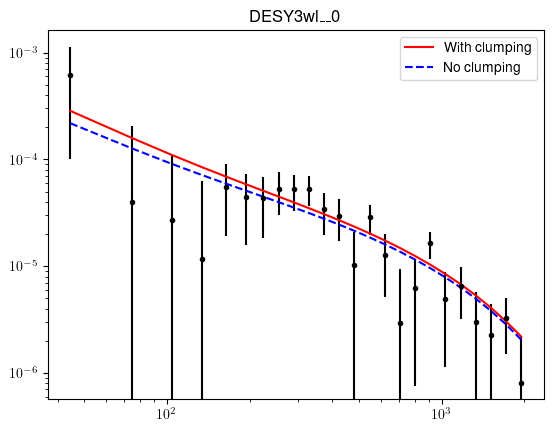

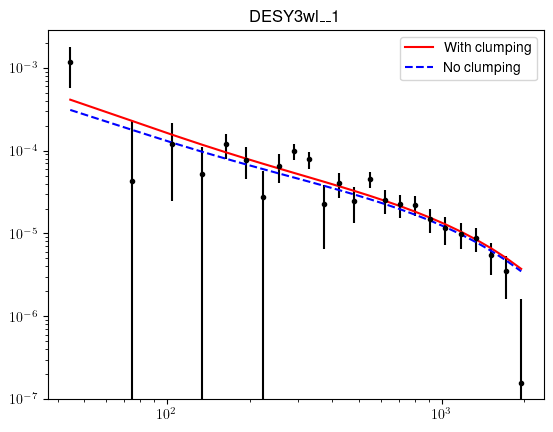

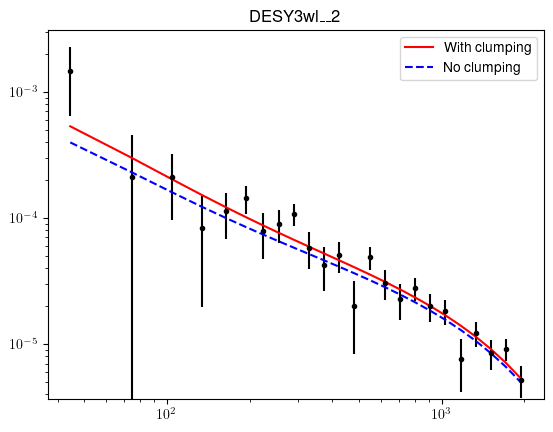

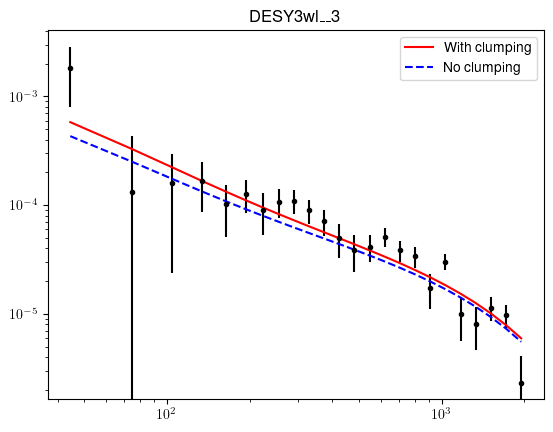

In [3]:
lc = ROSATxLike(params_vary=['logTAGN'],
                priors={'logTAGN': [7.5, 8.2]})
lnc = ROSATxLike(params_vary=['logTAGN'],
                 priors={'logTAGN': [7.5, 8.2]}, with_clumping=False)
cls_c = lc.get_model(logTAGN=8.0)
cls_nc = lnc.get_model(logTAGN=8.0)

for i, d in enumerate(lc.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    plt.plot(d['ls'], cls_c[i], '-', c='r', label='With clumping')
    plt.plot(d['ls'], cls_nc[i], '--', c='b', label='No clumping')
    plt.loglog()
    plt.legend()

data/Jtot_Z0.30.pck
703.5289258994359
[19658.72018770728, 10456.447756813122, 5176.502132925989, 2309.484907351458, 423.53671645092675, 83.3491354736498, 205.59822797381423, 385.54792181456816]
96


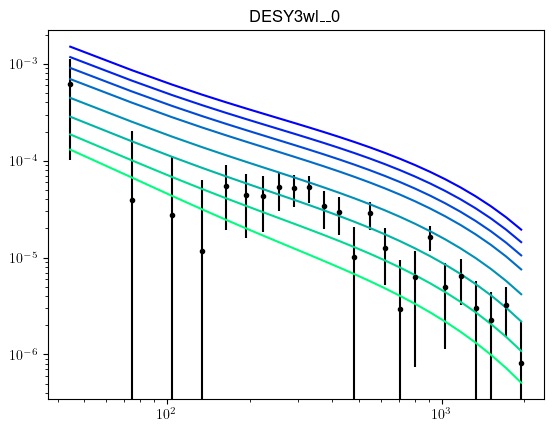

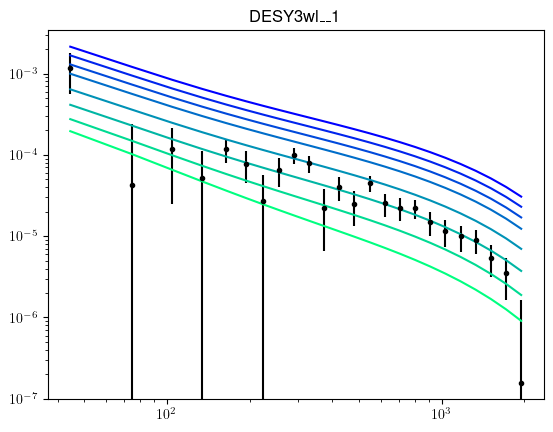

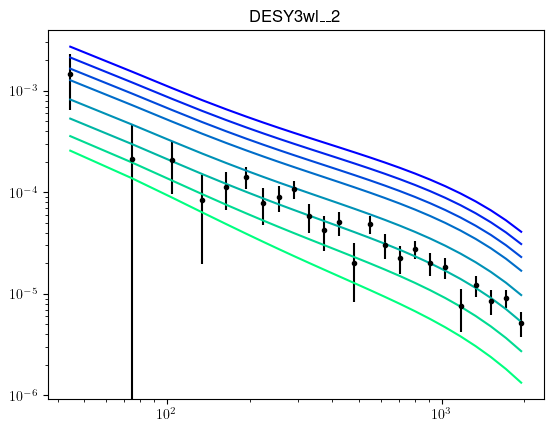

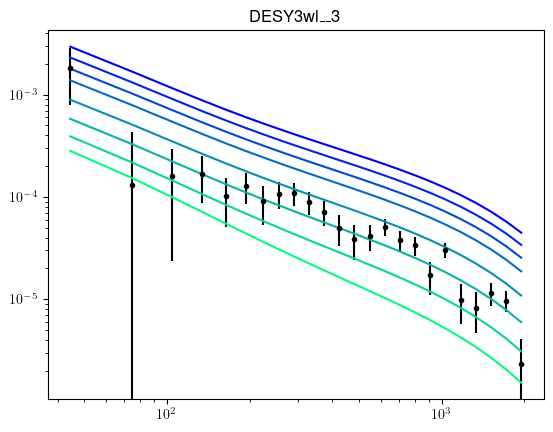

In [4]:
l = ROSATxLike(params_vary=['logTAGN'],
               priors={'logTAGN': [7.5, 8.2]})

chi20 = np.dot(l.data, np.dot(l.inv_cov, l.data))
print(chi20)

pars = [{'logTAGN': 7.5},
        {'logTAGN': 7.6},
        {'logTAGN': 7.7},
        {'logTAGN': 7.8},
        {'logTAGN': 7.9},
        {'logTAGN': 8.0},
        {'logTAGN': 8.1},
        {'logTAGN': 8.2}]
clms = [l.get_model(**p) for p in pars]
chi2s = [-2*l.get_logp(**p) for p in pars]
print(chi2s)
print(l.ndata)


npar = len(pars)
color = plt.cm.winter(np.linspace(0, 1, npar))
for i, d in enumerate(l.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    for j in range(npar):
        plt.plot(d['ls'], clms[j][i], '-', c=color[j])
    plt.loglog()


In [5]:
print("S/N = ", np.sqrt(chi20-np.amin(np.array(chi2s))))

S/N =  24.90340921291272


In [6]:
logTAGNs = np.linspace(7.92, 8.15, 256)
lMcs, gammas, alpha_Ts, logTw0s, Tw1s = np.array([l.prof_dens.from_logTAGN(lt) for lt in logTAGNs]).T
chi2s = np.array([-2*l.logp([lT], per_bin=True) for lT in logTAGNs])

In [7]:
chi2s.shape

(256, 5)

In [8]:
print(np.amin(chi2s[:, -1]), logTAGNs[np.argmin(chi2s[:, -1])])

83.34566940958588 8.000274509803921


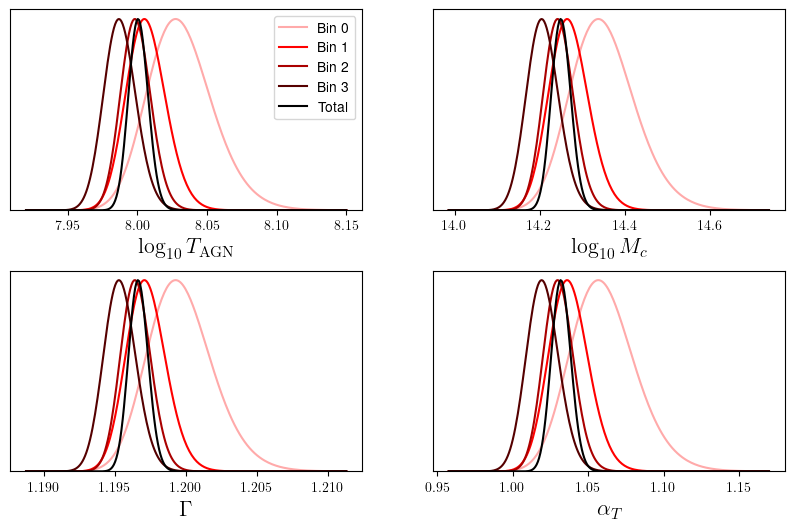

In [9]:
fig, axes = plt.subplots(2, 2,
                         figsize=(10, 6),
                         sharex=False,
                         sharey=True)
plt.subplots_adjust(hspace=0.3)
probs = np.exp(-0.5*(chi2s-np.amin(chi2s, axis=0)[None, :]))
axes = axes.flatten()
cols = ['#FFAAAA', '#FF0000', '#AA0000', '#550000', '#000000']
labels = [f'Bin {i}' for i in range(4)] + ['Total']
for p, c, lab in zip(probs.T, cols, labels):
    axes[0].plot(logTAGNs, p, '-', c=c, label=lab)
    axes[0].set_xlabel(r'$\log_{10}T_{\rm AGN}$', fontsize=16)
    axes[1].plot(lMcs, p, '-', c=c, label=lab)
    axes[1].set_xlabel(r'$\log_{10}M_c$', fontsize=16)
    axes[2].plot(gammas, p, '-', c=c, label=lab)
    axes[2].set_xlabel(r'$\Gamma$', fontsize=16)
    axes[3].plot(alpha_Ts, p, '-', c=c, label=lab)
    axes[3].set_xlabel(r'$\alpha_T$', fontsize=16)
axes[0].legend()
for ax in axes:
    ax.set_ylim([0, 1.05])
    ax.set_yticks([])